In [ ]:
!python -m deeppavlov install config_file

/usr/bin/python3: No module named deeppavlov


In [ ]:
!pip install deeppavlov==0.5.0

In [ ]:
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import random

In [ ]:
train = pd.read_excel('/content/unbalanced_train.xlsx')
test = pd.read_excel('/content/data_test.xlsx')

In [ ]:
def df_tolist(data):
    df = []
    for i, row in data.iterrows():
        if str(row['index']) == '1':
            df.append((row['текст_спел'], '1'))
        elif str(row['index']) == '0':
            df.append((row['текст_спел'], '0'))
        elif str(row['index']) == '2':
            df.append((row['текст_спел'], '2'))
    return df

In [ ]:
train = df_tolist(train)
test = df_tolist(test)

In [ ]:
df1 = {'train' : train, 'test' : test}

In [ ]:
import sys
!{sys.executable} -m pip install --user deeppavlov

In [ ]:
!pip3 install deeppavlov
from deeppavlov.dataset_iterators.basic_classification_iterator import BasicClassificationDatasetIterator

In [ ]:
iterator = BasicClassificationDatasetIterator(df1, seed=42, shuffle=True)

In [ ]:
!python -m deeppavlov install squad_bert

In [ ]:
from deeppavlov.models.preprocessors.bert_preprocessor import BertPreprocessor

In [ ]:
from urllib.request import urlretrieve
import os.path

In [ ]:
destination = 'rubert_cased_L-12_H-768_A-12_v2.tar.gz'
url = 'http://files.deeppavlov.ai/deeppavlov_data/bert/rubert_cased_L-12_H-768_A-12_v2.tar.gz'
urlretrieve(url, destination)


('rubert_cased_L-12_H-768_A-12_v2.tar.gz',
 <http.client.HTTPMessage at 0x7f61380bcc90>)

In [ ]:
!tar -xzf '/content/rubert_cased_L-12_H-768_A-12_v2.tar.gz'

In [ ]:
bert_preprocessor = BertPreprocessor(vocab_file="/content/rubert_cased_L-12_H-768_A-12_v2/vocab.txt",
                                     do_lower_case=False,
                                     max_seq_length=64)

In [ ]:
from deeppavlov.core.data.simple_vocab import SimpleVocabulary

In [ ]:
vocab = SimpleVocabulary(save_path="./binary_classes.dict")

In [ ]:
vocab.fit(iterator.get_instances(data_type="train")[1])

In [ ]:
from deeppavlov.models.preprocessors.one_hotter import OneHotter

In [ ]:
one_hotter = OneHotter(depth=vocab.len, 
                       single_vector=True
                      )

In [ ]:
one_hotter(vocab(["0", "1", "2"]))

[array([0., 0., 1.], dtype=float32),
 array([0., 1., 0.], dtype=float32),
 array([1., 0., 0.], dtype=float32)]

In [ ]:
from deeppavlov.models.classifiers.proba2labels import Proba2Labels
prob2labels = Proba2Labels(max_proba=True)

In [ ]:
from deeppavlov.models.bert.bert_classifier import BertClassifierModel
from deeppavlov.metrics.accuracy import sets_accuracy

In [ ]:
bert_classifier = BertClassifierModel(
    n_classes=vocab.len,
    return_probas=True,
    one_hot_labels=True,

    bert_config_file="/content/rubert_cased_L-12_H-768_A-12_v2/bert_config.json",
    pretrained_bert="/content/rubert_cased_L-12_H-768_A-12_v2/bert_model.ckpt",
    
    save_path="/content/sst_bert_model/model_no_balance",
    load_path="/content/sst_bert_model/model_no_balance",
    keep_prob=0.5,
    learning_rate=1e-05,
    learning_rate_drop_patience=1,
    learning_rate_drop_div=2.0
)


In [ ]:
x_valid, y_valid = iterator.get_instances(data_type="test")
best_score = 0.
patience = 2
impatience = 0

for ep in range(2):
  
    nbatches = 0
    for x, y in iterator.gen_batches(batch_size=64, 
                                     data_type="train", shuffle=True):
        x_feat = bert_preprocessor(x)
        y_onehot = one_hotter(vocab(y))
        bert_classifier.train_on_batch(x_feat, y_onehot)
        nbatches += 1
        
        if nbatches % 10 == 0:
            y_valid_pred = bert_classifier(bert_preprocessor(x_valid))
            score = sets_accuracy(y_valid, vocab(prob2labels(y_valid_pred)))
            print("Batches done: {}. Valid Accuracy: {}".format(nbatches, score))
            
    y_valid_pred = bert_classifier(bert_preprocessor(x_valid))
    score = sets_accuracy(y_valid, vocab(prob2labels(y_valid_pred)))
    print("Epochs done: {}. Valid Accuracy: {}".format(ep + 1, score))
    if score > best_score:
        bert_classifier.save()
        print("New best score. Saving model.")
        best_score = score    
        impatience = 0
    else:
        impatience += 1
        if impatience == patience: 
            print("Out of patience. Stop training.")
            break

In [ ]:
x_valid, y_valid = iterator.get_instances(data_type="test")
bert_classifier.load()
y_valid_pred = bert_classifier(bert_preprocessor(x_valid))

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
print("Text sample: {}".format(x_valid[0]))
print("True label: {}".format(y_valid[0]))
print("Predicted  probability distribution: {}".format(dict(zip(vocab.keys(), 
                                                               y_valid_pred[0]))))
print("Predicted label: {}".format(vocab(prob2labels(y_valid_pred))[0]))
print()
print(classification_report(y_valid, vocab(prob2labels(y_valid_pred))))
print(sets_accuracy(y_valid, vocab(prob2labels(y_valid_pred))))


                                                               

Text sample: ты че несешь )) с какими мусульманами че там у тебя начнется хахах)))
True label: 1
Predicted  probability distribution: {'0': 0.075029984, '2': 0.5533285, '1': 0.3716415}
Predicted label: ['2']

              precision    recall  f1-score   support

           0       0.72      0.74      0.73       585
           1       0.58      0.47      0.52       579
           2       0.69      0.81      0.74       539

    accuracy                           0.67      1703
   macro avg       0.66      0.67      0.66      1703
weighted avg       0.66      0.67      0.66      1703

0.6694069289489136


Text(0.5, 1.0, 'Normalized confusion matrix for unbalanced RuBERT')

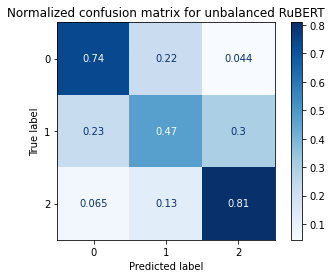

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

class_names = ['0', '1', '2']

cm = confusion_matrix(y_valid, vocab(prob2labels(y_valid_pred)), class_names)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

disp = disp.plot(include_values=class_names, cmap=plt.cm.Blues) 
disp.ax_.set_title("Normalized confusion matrix for unbalanced RuBERT")